In [2]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from typing import *
import matplotlib.pyplot as plt
import numpy as np
from LFCNN_decoder import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions
import pickle
import scipy as sp
import pandas as pd
import matplotlib.gridspec as gspec
from utils.storage_management import read_pkl

2023-09-10 15:46:45.400253: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 15:46:45.677119: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 15:46:45.678074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 15:46:47.198109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
def plot_stars(n_box, n_stars, star_symbol='*', height=1.125):
    if n_stars%2:
        distances = [np.round((i-n_stars//2)*.4, 2) for i in range(n_stars)]
    else:
        distances = list(map(
            lambda x: x[1] if x[0] >= n_stars//2 else -x[1],
            enumerate(map(
                lambda x: np.round(.2 + x*.4, 2) if x != 0 else .2,
                [i for i in range(n_stars//2)][::-1] + list(range(n_stars//2))
            ))
        ))

    for distance in distances:
        plt.plot(n_box+distance, height, star_symbol, c='#1f77b4', ms=10)


def put_letter(letter: str, axis: plt.Axes, size: int = 20, coords: tuple[float, float] = (0.5, 0.5)):
    axis.text(*coords, letter, fontsize=size, horizontalalignment='center', verticalalignment='center')
    axis.axis('off')

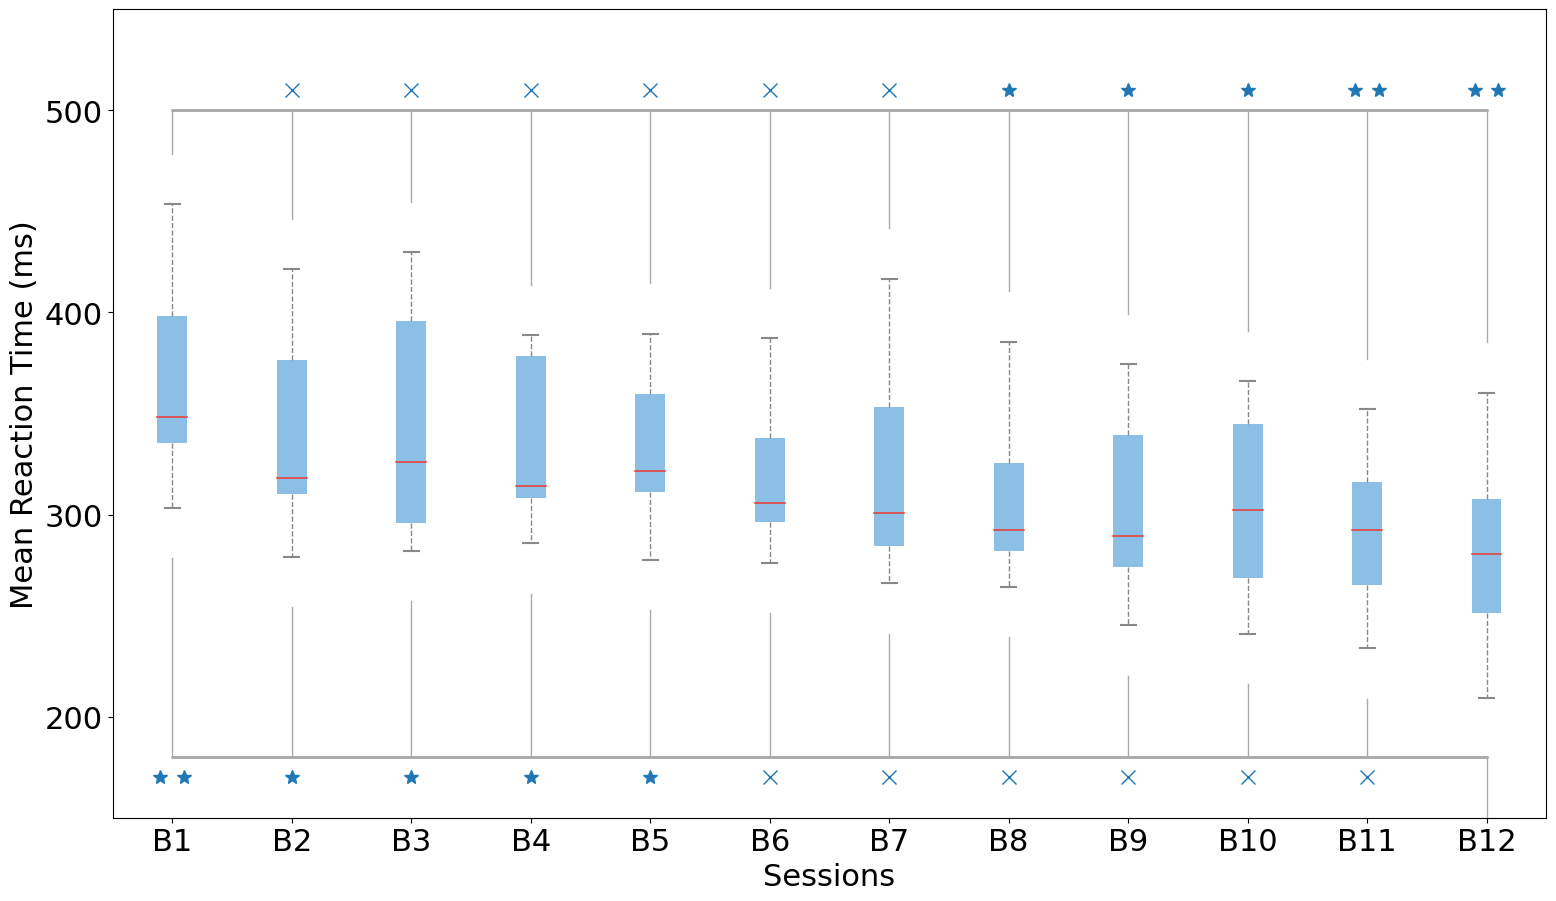

In [3]:
plt.rcParams.update({'font.size': 22})

path = '../Source/perf_data/MEG_SRTT_RT.xlsx'
df = pd.read_excel(path, index_col=1)
for index in df.columns:
    if not isinstance(index, (int, float)) or index > 12:
        df.drop(index, axis=1, inplace=True)
indices = [i for i in range(2*len(df.columns)) if (i+1)%2]
boxplot = plt.boxplot(df, patch_artist=True, positions=indices, showfliers=False)
color = '#888'
width = 1

for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor('#66aadd')
    box.set_alpha(.75)
    box.set_linewidth(0)
for box in boxplot['caps']:
    box.set_color(color)
    box.set_linewidth(width*1.5)
for box in boxplot['whiskers']:
    box.set_color(color)
    box.set_linewidth(width)
    box.set_linestyle('--')
for box in boxplot['medians']:
    box.set_color('#FF1E0F')
    box.set_linewidth(width*1.25)
    box.set_alpha(.75)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
xmin = -1
xmax = 2*len(df.columns)-1
plt.xlim([xmin, xmax])
get_x = lambda x: (x - xmin)/(xmax - xmin)
ymin = 150
ymax = 550
plt.ylim([ymin, ymax])
get_y = lambda y: (y - ymin)/(ymax - ymin)

for i, drange in zip([1, 12], [range(12), list(range(12))[::-1]]):
    if i == 1:
        height = 510
    if i == 12:
        height = 170
    for j in drange:
        if j+1 == i:
            continue
        s, p = sp.stats.ttest_ind(df[i], df[j+1])
        if p >= .05:
            plot_stars(indices[j], 1, star_symbol='x', height=height)
        elif .01 <= p < .05:
            plot_stars(indices[j], 1, height=height)
        elif .001 <= p < .01:
            plot_stars(indices[j], 2, height=height)
        elif p < .001:
            plot_stars(indices[j], 3, height=height)

for i, data in enumerate(df.to_numpy().T):
    q1 = np.percentile(data, 0)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    p1 = min(
        filter(
            lambda datum: q1-1.5*iqr <= datum <= q1,
            data
        )
    )
    p2 = max(
        filter(
            lambda datum: q3 <= datum <= q3+1.5*iqr,
            data
        )
    )
    # .4 is min ylim
    plt.axvline(indices[i], get_y(p2+25), get_y(500), linewidth=1, color='#aaa')
    plt.axvline(indices[i], get_y(p1-25), get_y(180), linewidth=1, color='#aaa')
    plt.axhline(500, get_x(indices[0]), get_x(indices[-1]), linewidth=1, color='#aaa')
    plt.axhline(180, get_x(indices[0]), get_x(indices[-1]), linewidth=1, color='#aaa')

plt.xlabel('Sessions')
plt.ylabel('Mean Reaction Time (ms)')
_ = plt.xticks([i-1 for i in range(2*len(df.columns)) if i%2], [f'B{int(i)}' for i in df.columns])
_ = plt.yticks([200, 300, 400, 500])
figname = path.split('/')[-1].split('.')[0]
plt.savefig(f'/home/user/Downloads/Pics/{figname}.jpg', dpi=300)
plt.show()


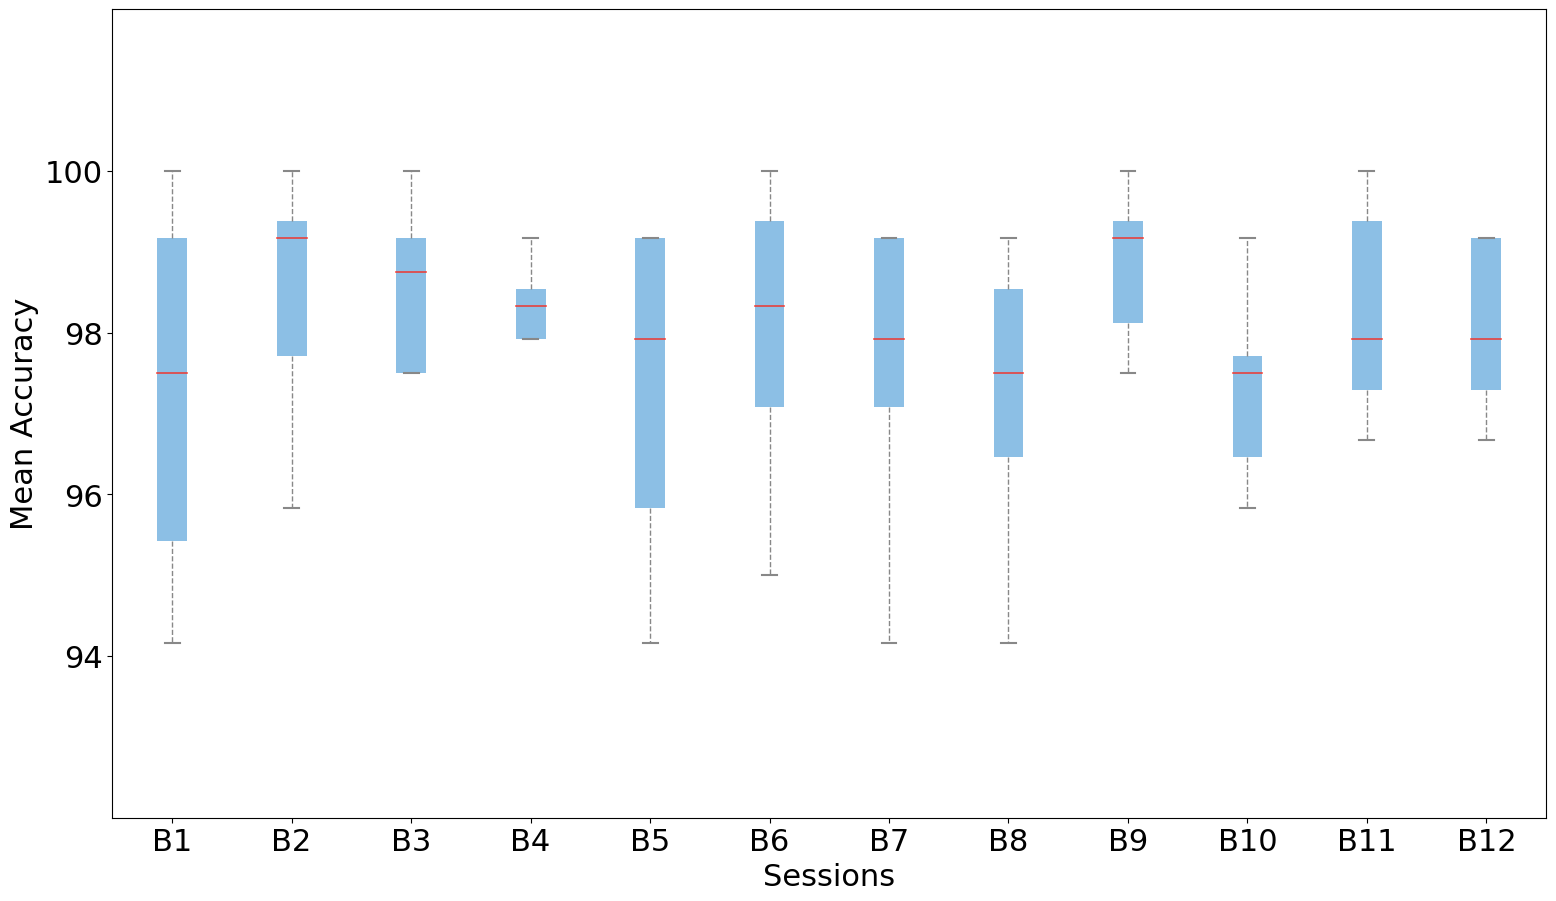

In [4]:
path = '../Source/perf_data/MEG_SRTT_ACC.csv'
df = pd.read_csv(path, index_col=1)

for index in df.columns:
    if not str.isdigit(index) or int(index) > 12:
        df.drop(index, axis=1, inplace=True)

indices = [i for i in range(2*len(df.columns)) if (i+1)%2]
df = df.dropna()
boxplot = plt.boxplot(df, patch_artist=True, positions=indices, showfliers=False)
color = '#888'

for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor('#66aadd')
    box.set_alpha(.75)
    box.set_linewidth(0)
for box in boxplot['caps']:
    box.set_color(color)
    box.set_linewidth(width*1.5)
for box in boxplot['whiskers']:
    box.set_color(color)
    box.set_linewidth(width)
    box.set_linestyle('--')
for box in boxplot['medians']:
    box.set_color('#FF1E0F')
    box.set_linewidth(width*1.25)
    box.set_alpha(.75)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
xmin = -1
xmax = 2*len(df.columns)-1
plt.xlim([xmin, xmax])
get_x = lambda x: (x - xmin)/(xmax - xmin)
ymin = 92
ymax = 102
plt.ylim([ymin, ymax])
get_y = lambda y: (y - ymin)/(ymax - ymin)
plt.xlabel('Sessions')
plt.ylabel('Mean Accuracy')
_ = plt.xticks([i-1 for i in range(2*len(df.columns)) if i%2], [f'B{int(i)}' for i in df.columns])
_ = plt.yticks([94, 96, 98, 100])
figname = path.split('/')[-1].split('.')[0]
plt.savefig(f'/home/user/Downloads/Pics/{figname}.jpg', dpi=300)
plt.show()

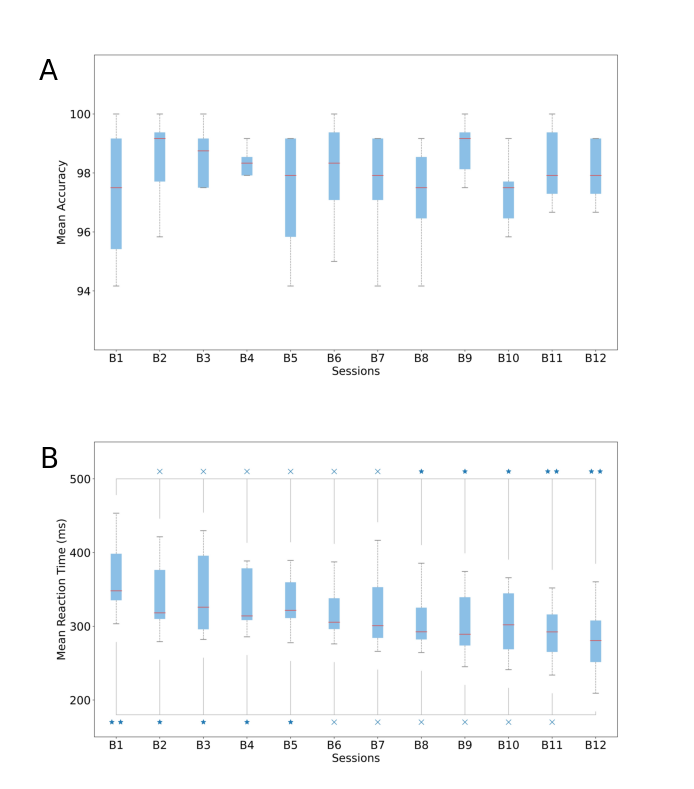

In [20]:
figsize = 10, 10
fontsize = 20
figpat = 'fig3'
pics_dir = '/home/user/Documents/FingerMovementDecoder/Paper/pics'
fig_paths = [os.path.join(pics_dir, path) for path in os.listdir(pics_dir) if figpat in path.lower() and ('a' in path.lower() or 'b' in path.lower())]
fig_images = [plt.imread(path) for path in fig_paths]

fig = plt.figure(figsize = figsize)
gs = gspec.GridSpec(30, 30)

topo_axes = [
    fig.add_subplot(gs[:15, :]),
    fig.add_subplot(gs[15:, :]),
]

for ax, image in zip(topo_axes, fig_images):
        ax.imshow(image)
        ax.axis('off')

ax0_1 = fig.add_subplot(gs[2, 3])
put_letter('A', ax0_1, fontsize)
ax0_2 = fig.add_subplot(gs[17, 3])
put_letter('B', ax0_2, fontsize)

fig.savefig(os.path.join(pics_dir, f'{figpat}.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()